In [35]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs import encode_float_filename, decode_float_filename, compute_f1_scores, compute_weighted_f1_score, quadratic_weighted_kappa
from libs.MarkovModel import generate_balanced_thresholds
from libs.MarkovModel import assign_groups

In [36]:
def generate_thresholds(L: int, N: int) -> list:
    """
    Generate thresholds to split the range [0, L] into N groups.

    Parameters:
    L (int): The range limit.
    N (int): Number of groups.

    Returns:
    list: List of N-1 threshold values.
    """
    if N <= 1:
        raise ValueError("N must be greater than 1.")
    
    step = L / N
    ths = [round(step * i) for i in range(1, N)]
    return ths

In [32]:
dbParams_list = [0.01, 0.15]
direction_list = ["forward", "backward"]
#dbParams_list = [0.01]
#direction_list = ["forward"]
mode_list = ["fixed", "adaptive"]
LEN_period = 1000
verbose = False

mseCF_results = {}
mseCA_results = {}
f1ScoreCF_results = {}
f1ScoreCA_results = {}
N_group_list = [5,10,15]
lenWindow_list = [10, 20, 30]

for dbParams, direction in zip(dbParams_list, direction_list):
    for mode in mode_list:
        mseCF_row = []
        mseCA_row = []
        f1ScoreCF_row = []
        f1ScoreCA_row = []
        for (lenWindow, N_group) in zip(lenWindow_list, N_group_list):
            #print(lenWindow, N_group)
            dbpString = encode_float_filename(dbParams)
            with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
                resultsCA_Train = pickle.load(file)
            with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
                resultsCA_Test = pickle.load(file)
            with open(f"Results/TrafficPredictor/evaluate/CF/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
                resultsCF_Train = pickle.load(file)
            with open(f"Results/TrafficPredictor/evaluate/CF/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
                resultsCF_Test = pickle.load(file)
 
            thereshold_Train, ratio = generate_balanced_thresholds(resultsCA_Train['trafficTarget_actual'].astype(int), N_group)
            #thereshold_Train = generate_thresholds(lenWindow+1, N_group)
            #print(thereshold_Train)
            qwk_score_CA = quadratic_weighted_kappa(
                assign_groups(resultsCA_Test['trafficTarget_actual'].astype(int), thereshold_Train), 
                assign_groups(resultsCA_Test['trafficTarget_predicted'].astype(int), thereshold_Train), 
                N_group
            )
            qwk_score_CF = quadratic_weighted_kappa(
                assign_groups(resultsCF_Test['trafficTarget_actual'].astype(int), thereshold_Train), 
                assign_groups(resultsCF_Test['trafficTarget_predicted'].astype(int), thereshold_Train), 
                N_group
            )
            
            '''
            qwk_score_CA = quadratic_weighted_kappa(
                resultsCA_Test['trafficTarget_actual'].astype(int), 
                resultsCA_Test['trafficTarget_predicted'].astype(int), 
                lenWindow+1
            )
            qwk_score_CF = quadratic_weighted_kappa(
                resultsCF_Test['trafficTarget_actual'].astype(int), 
                resultsCF_Test['trafficTarget_predicted'].astype(int), 
                lenWindow+1
            )
            '''
            #mse_CA = np.mean(abs(resultsCA_Test['trafficTarget_predicted'].astype(int) - resultsCA_Test['trafficTarget_actual'].astype(int)))
            #mse_CF = np.mean(abs(resultsCF_Test['trafficTarget_predicted'].astype(int) - resultsCF_Test['trafficTarget_actual'].astype(int)))
            mse_CA = np.mean((resultsCA_Test['trafficTarget_predicted'] - resultsCA_Test['trafficTarget_actual'])**2)
            mse_CF = np.mean((resultsCF_Test['trafficTarget_predicted'] - resultsCF_Test['trafficTarget_actual'])**2)

            mseCA_row.append(np.mean(mse_CA))
            mseCF_row.append(np.mean(mse_CF))
            f1ScoreCA_row.append(np.mean(qwk_score_CA))
            f1ScoreCF_row.append(np.mean(qwk_score_CF))
            if verbose == True:
                print(f"======== lenWindow: {lenWindow}, dbParams: {dbParams}, direction: {direction}, mode: {mode}")    
                print(thereshold_Train)
                print(f"f1_scores_CA: {qwk_score_CA}, mse_CA: {mse_CA}")
                print(f"f1_scores_CF: {qwk_score_CF}, mse_CF: {mse_CF}")

                N_obv=200
                plt.plot(resultsCF_Test['trafficTarget_actual'][:N_obv].astype(int))
                plt.plot(resultsCF_Test['trafficTarget_predicted'][:N_obv].astype(int))
                plt.show()
                plt.plot(resultsCA_Test['trafficTarget_actual'][:N_obv].astype(int))
                plt.plot(resultsCA_Test['trafficTarget_predicted'][:N_obv].astype(int))
                plt.show()
        mseCA_results[(direction, mode)] = np.array(mseCA_row)
        mseCF_results[(direction, mode)] = np.array(mseCF_row)
        f1ScoreCA_results[(direction, mode)] = np.array(f1ScoreCA_row)
        f1ScoreCF_results[(direction, mode)] = np.array(f1ScoreCF_row)     

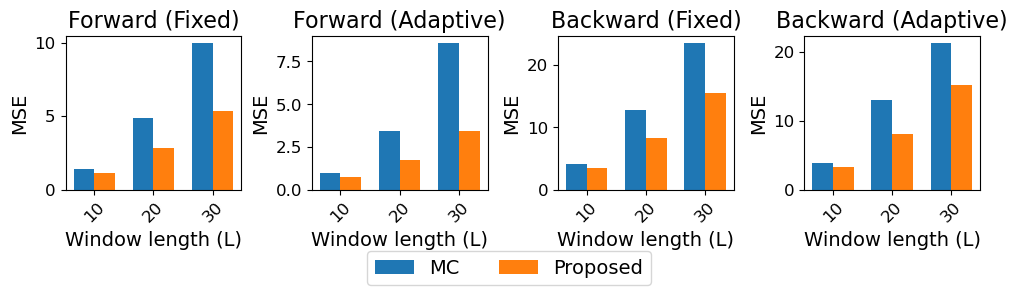

In [33]:
def plot_combined_comparison_bar_graph(perpCF_results: dict, perpCA_results: dict, configurations, subtitles, figsize=(12, 12), 
                                       title_fontsize=14, label_fontsize=12, tick_fontsize=10, legend_fontsize=12, yLabel="xx") -> None:
    # Creating the figure with 1x4 subplots
    fig, axs = plt.subplots(1, 4, figsize=figsize)
    axs = axs.ravel()  # Flatten for easier indexing

    for i, config in enumerate(configurations):
        ax = axs[i]
        source1 = perpCF_results[config].reshape(-1, 1)
        source2 = perpCA_results[config].reshape(-1, 1)

        # Ensuring equal length of sources
        if source1.shape[0] != source2.shape[0]:
            raise ValueError("Both sources must have the same number of groups (N).")

        N = source1.shape[0]
        indices = np.arange(N)
        bar_width = 0.35

        # Plotting bars
        ax.bar(indices - bar_width / 2, source1.flatten(), width=bar_width, label='MC')
        ax.bar(indices + bar_width / 2, source2.flatten(), width=bar_width, label='Proposed')

        ax.set_title(f'{subtitles[i]}', fontsize=title_fontsize)
        ax.set_xlabel('Window length (L)', fontsize=label_fontsize)
        ax.set_ylabel(yLabel, fontsize=label_fontsize)
        ax.set_xticks(indices)
        ax.set_xticklabels(['10', '20', '30'], rotation=45, fontsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    # Adjust layout and add one single legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=legend_fontsize)

    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
    return fig

configurations = [
    ('forward', 'fixed'),
    ('forward', 'adaptive'),
    ('backward', 'fixed'),
    ('backward', 'adaptive')
]
subtitles = [
    'Forward (Fixed)',
    'Forward (Adaptive)',
    'Backward (Fixed)',
    'Backward (Adaptive)'
]
fig = plot_combined_comparison_bar_graph(
    mseCF_results, 
    mseCA_results, 
    configurations, 
    subtitles, 
    figsize=(10, 3), 
    title_fontsize=16, 
    label_fontsize=14, 
    tick_fontsize=12, 
    legend_fontsize=14,
    yLabel="MSE"
)
fig.savefig("C:/Users/Ye/Documents/YuYeh_Documents/L2S/Conference_Writing/EW2025/figures/MSE.png", format='png', dpi=300)

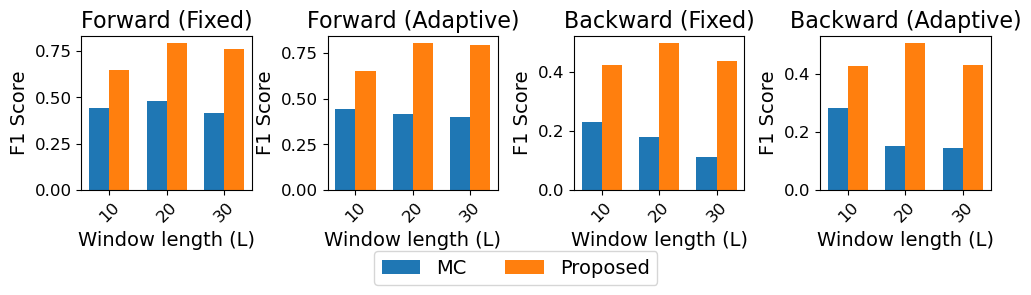

In [ ]:
configurations = [
    ('forward', 'fixed'),
    ('forward', 'adaptive'),
    ('backward', 'fixed'),
    ('backward', 'adaptive')
]
subtitles = [
    'Forward (Fixed)',
    'Forward (Adaptive)',
    'Backward (Fixed)',
    'Backward (Adaptive)'
]
fig = plot_combined_comparison_bar_graph(
    f1ScoreCF_results, 
    f1ScoreCA_results, 
    configurations, 
    subtitles, 
    figsize=(10, 3), 
    title_fontsize=16, 
    label_fontsize=14, 
    tick_fontsize=12, 
    legend_fontsize=14,
    yLabel="F1 Score"
)
fig.savefig("C:/Users/Ye/Documents/YuYeh_Documents/L2S/Conference_Writing/EW2025/figures/f1_score.png", format='png', dpi=300)